In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
import matplotlib.cm as cm
import matplotlib.colors as mcolors

import xtrack as xt
import xpart as xp
import xobjects as xo
import xcoll as xc

# Tune plot for different chroma

In [2]:
line = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta4.json')
env = line.env

line_linear = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta4.json')
env_linear = line_linear.env

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           


Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           


In [3]:
# Installing errors
tte = env.elements.get_table()
mask_rbends = tte.element_type == 'RBend'
mask_quads = tte.element_type == 'Quadrupole'
mask_sextupoles = tte.element_type == 'Sextupole'

mba = tte.rows[mask_rbends].rows['mba.*'].name
mbb = tte.rows[mask_rbends].rows['mbb.*'].name
qf = tte.rows[mask_quads].rows['qf.*'].name
qd = tte.rows[mask_quads].rows['qd.*'].name
lsf = tte.rows[mask_sextupoles].rows['lsf.*'].name
lsd = tte.rows[mask_sextupoles].rows['lsd.*'].name

for nn in mba:
    env[nn].knl = np.array([0., 0., 2.12e-3, 0., -5.74, 0.])

for nn in mbb:
    env[nn].knl = np.array([0., 0., -3.19e-3, 0., -5.10, 0.])

for nn in qf:
    env[nn].knl = np.array([0., 0., 0., 0.75e-1, 0., -0.87e3])

for nn in qd:
    env[nn].knl = np.array([0., 0., 0., -2.03e-1, 0., 2.04e3])

In [5]:
#Optimisation
deltas = np.linspace(-4e-3, 3.9e-3, 21)
twisses = {}
twisses_lin = {}
qx = 20.13
qy = 20.18
# dqx_calc = (20.09-20.13)/(-3.1e-3)
# dqy_calc = 1e-2/6
chromas_norm = np.linspace(0.5, 1.0, 6) #negatives dont twiss for lin line, and up to 0.5 no twiss possible for error

for c in chromas_norm:
    dqx_calc = c * qx
    dqy_calc = c * qy
    opt = line.match(
        method='6d', # <- passed to twiss
        vary=[
            xt.VaryList(['kqf0', 'kqd0'], step=1e-8, tag='quad'),
            xt.VaryList(['qph_setvalue', 'qpv_setvalue'], step=1e-4, tag='sext'),
        ],
        targets = [
            xt.TargetSet(qx=qx, qy=qy, tol=1e-6, tag='tune'),
            xt.TargetSet(dqx=dqx_calc, dqy=dqy_calc, tol=1e-2, tag='chrom'),
        ])
    
    opt_lin = line_linear.match(
        method='6d', # <- passed to twiss
        vary=[
            xt.VaryList(['kqf0', 'kqd0'], step=1e-8, tag='quad'),
            xt.VaryList(['qph_setvalue', 'qpv_setvalue'], step=1e-4, tag='sext'),
        ],
        targets = [
            xt.TargetSet(qx=qx, qy=qy, tol=1e-6, tag='tune'),
            xt.TargetSet(dqx=dqx_calc, dqy=dqy_calc, tol=1e-2, tag='chrom'),
        ])
    
    twisses[c] = [line.twiss4d(delta0=d) for d in deltas]
    twisses_lin[c] = [line_linear.twiss4d(delta0=d) for d in deltas]


                                             
Optimize - start penalty: 0.01056                           
Matching: model call n. 2 penalty = 1.0559e-02              
Optimize - end penalty:  0.0105587                            
                                             
Optimize - start penalty: 1.314e-06                         
Matching: model call n. 2 penalty = 1.3145e-06              
Optimize - end penalty:  1.31447e-06                            
                                             
Optimize - start penalty: 2.853                             
Matching: model call n. 7 penalty = 1.5638e-03              
Optimize - end penalty:  0.00156378                            
                                             
Optimize - start penalty: 2.85                              
Matching: model call n. 7 penalty = 4.3664e-04              
Optimize - end penalty:  0.000436644                            
                                             
Optimize - start penalty:

## Tune vs $\delta$ : $Q_{x,y} = Q_{x,y, 0} + Q_{x,y}^{'} \cdot \delta + Q_{x,y}^{''} \cdot \frac{\delta^2}{2} + ...$

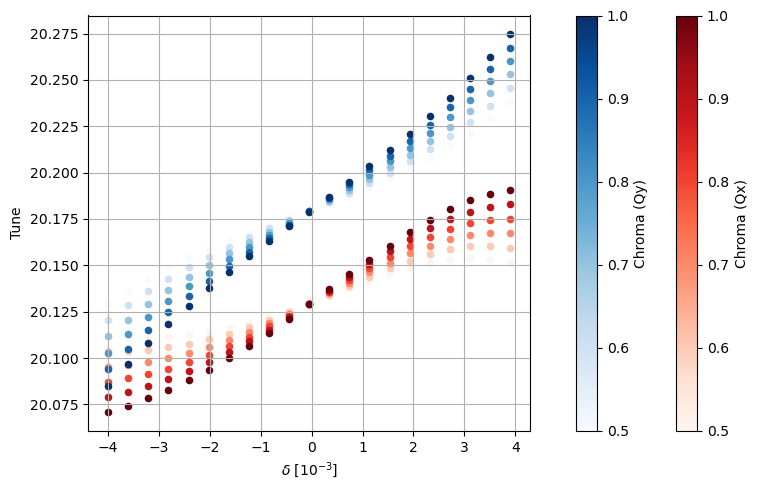

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

# Normalization over chromas
norm = mcolors.Normalize(vmin=min(chromas_norm), vmax=max(chromas_norm))

# Colormaps
cmap_qx = cm.Reds
cmap_qy = cm.Blues

for c in chromas_norm:
    ax.scatter(
        deltas * 1e3,
        [twiss.qx for twiss in twisses[c]],
        color=cmap_qx(norm(c)),
        s=20
    )

    ax.scatter(
        deltas * 1e3,
        [twiss.qy for twiss in twisses[c]],
        color=cmap_qy(norm(c)),
        s=20
    )

ax.grid()
ax.set_xlabel(r'$\delta$ [$10^{-3}$]')
ax.set_ylabel('Tune')

# --- Colorbars on the side ---
sm_qx = cm.ScalarMappable(norm=norm, cmap=cmap_qx)
sm_qx.set_array([])
cbar_qx = fig.colorbar(sm_qx, ax=ax, pad=0.02)
cbar_qx.set_label('Chroma (Qx)')

sm_qy = cm.ScalarMappable(norm=norm, cmap=cmap_qy)
sm_qy.set_array([])
cbar_qy = fig.colorbar(sm_qy, ax=ax, pad=0.08)
cbar_qy.set_label('Chroma (Qy)')

fig.tight_layout()
plt.savefig("Figures/tune_vs_delta.png")


Tune evolution is dominated by third order, as Hannes said

## Orbit and dispersion (arbitrarily at qd.31110)

(0.0, 1.0)

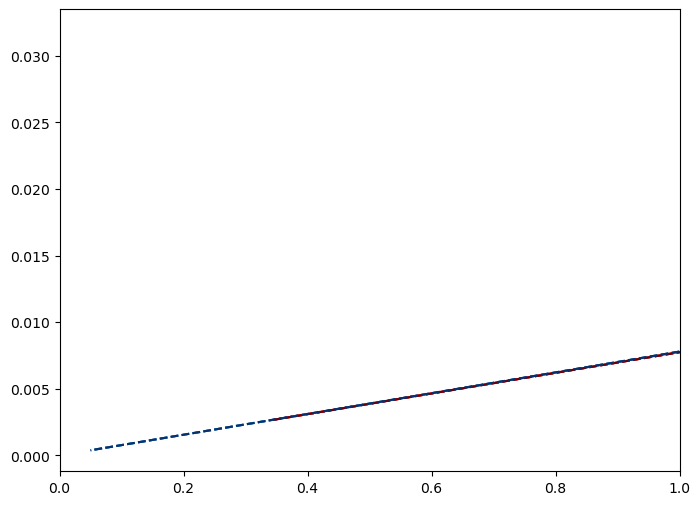

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

idxs_pos = np.where(deltas >= 0)[0]
idxs_neg = np.where(deltas <= 0)[0]

cmap_neg = cm.Reds
cmap_pos = cm.Blues
for c in chromas_norm:
    x_pos_err = np.array([twisses[c][idx].rows['qf.31010'].x[0] for idx in idxs_pos])
    x_neg_err = np.array([twisses[c][idx].rows['qf.31010'].x[0] for idx in idxs_neg])

    x_pos_lin = np.array([twisses_lin[c][idx].rows['qf.31010'].x[0] for idx in idxs_pos])
    x_neg_lin = np.array([twisses_lin[c][idx].rows['qf.31010'].x[0] for idx in idxs_neg])
    # ax.plot(
    #     deltas[idxs_pos] * 1e3,
    #     x_pos_err,
    #     color=cmap_pos(norm(c))
    # )
    # ax.plot(
    #     -deltas[idxs_neg] * 1e3,
    #     -x_neg_err,
    #     color=cmap_neg(norm(c)),
    # )
    ax.plot(
        deltas[idxs_pos] * 1e3,
        x_pos_lin,
        color=cmap_neg(norm(c)),
        ls = '--'
    )
    ax.plot(
        -deltas[idxs_neg] * 1e3,
        -x_neg_lin,
        color=cmap_pos(norm(c)),
        ls = '--'
    )
ax.set_xlim(0, 1)

In [55]:
twisses[c][idxs_pos[0]]

TwissTable: 32539 rows, 70 cols
name                             s             x            px             y            py ...
sps$start                        0    0.00269323   4.76221e-05   9.95342e-08  -2.37896e-08
begi.10010                       0    0.00269323   4.76221e-05   9.95342e-08  -2.37896e-08
qf.10010                         0    0.00269323   4.76221e-05   9.95342e-08  -2.37896e-08
drift_0..0                   3.085    0.00269035  -4.94731e-05   3.03491e-08  -2.14898e-08
veqf.10010.b_aper           3.2504    0.00268217  -4.94731e-05   2.67959e-08  -2.14898e-08
drift_0..1                  3.2504    0.00268217  -4.94731e-05   2.67959e-08  -2.14898e-08
veba.10030.a_aper           3.2516    0.00268211  -4.94731e-05   2.67701e-08  -2.14898e-08
drift_0..2                  3.2516    0.00268211  -4.94731e-05   2.67701e-08  -2.14898e-08
mba.10030_entry            3.44499    0.00267255  -4.94731e-05   2.26156e-08  -2.14898e-08
mba.10030..entry_map       3.44499    0.00267255  -4.9

In [53]:
idxs_pos[0][0]

np.int64(11)

In [45]:
idxs_pos = np.where(deltas >=0)

In [46]:
idxs_pos

(array([11, 12, 13, 14, 15, 16, 17, 18, 19, 20]),)

In [76]:
line_linear = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta4.json')
env_linear = line_linear.env

qx = 20.13
qy = 20.18
dqx_calc = 0.5 * qx
dqy_calc = 0.5 * qy

# opt_lin = line_linear.match(
#         method='6d', # <- passed to twiss
#         vary=[
#             xt.VaryList(['kqf0', 'kqd0'], step=1e-8, tag='quad'),
#             xt.VaryList(['qph_setvalue', 'qpv_setvalue'], step=1e-4, tag='sext'),
#         ],
#         targets = [
#             xt.TargetSet(qx=qx, qy=qy, tol=1e-6, tag='tune'),
#             xt.TargetSet(dqx=dqx_calc, dqy=dqy_calc, tol=1e-2, tag='chrom'),
#         ])

twisses_4d_pos = []
twisses_4d_neg = []
delta_sampling = np.linspace(0, 0.01, 100)
for i in range(len(delta_sampling)):
    if i % 100 == 0:
        print(f'Calculating twiss for delta {i}/{len(delta_sampling)}')
    # twisses_4d_pos.append(line.twiss(delta0=delta_sampling[i], method='4d'))
    twisses_4d_neg.append(line.twiss(delta0=-delta_sampling[i], method='4d'))

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
Calculating twiss for delta 0/100


ValueError: Invalid n1

In [75]:
delta_sampling[39]

np.float64(0.00393939393939394)

In [77]:
i

61

The delta sampling was too narrow and only limits to Hannes plot, so it is a bit useless for high $\delta$ analysis and dispersion. We need to probe more, but two problems:
- The apertures are limiting in probing twiss4d(delta0=...)
- The error line seems to be very sensitive to chroma -> in particular: the negative values are undoable (Hannes asked for them) -- even for the linear line (I think)

# Twisses with error lines